# 3D-реконструкция: демонстрации из модуля 6

В этом ноутбуке я показываю несколько эффектных демонстраций:

1. Радиальная дисторсия и её коррекция.
2. Эпиполярная геометрия и фундаментальная матрица.
3. Оценка глубины по одному изображению с помощью предобученной нейросети (MiDaS).

Ноутбук рассчитан на запуск в Google Colab.  
Для блока с нейросетью желательно включить GPU:
`Runtime → Change runtime type → Hardware accelerator: GPU`.


In [1]:
#@title Установка и базовые импорты
#!pip install -q opencv-python opencv-contrib-python matplotlib torch torchvision

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F

from pathlib import Path

print("Версия OpenCV:", cv2.__version__)
print("Версия PyTorch:", torch.__version__)
print("CUDA доступна:", torch.cuda.is_available())


Версия OpenCV: 4.12.0
Версия PyTorch: 2.8.0+cu126
CUDA доступна: True


## 2. Радиальная дисторсия: симуляция и коррекция

В этом блоке я показываю на практике идею со слайдов:

- как выглядит *бочкообразная* дисторсия;
- как можно её компенсировать обратным преобразованием.

Я беру обычное изображение, искусственно искажаю его с помощью простой
модели радиальной дисторсии, а затем применяю обратную модель и сравниваю
«до / после».

Обратите внимание на прямые линии — именно по ним хорошо видно эффект.


### 2.2 загрузка изображения и симуляция дисторсии

Здесь два сценария:
– либо качаем картинку по URL,
– либо загружаем свой файл (например, фото шахматной доски / здания).

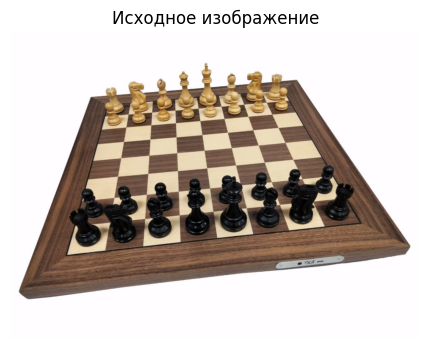

In [2]:
#@title Загрузка исходного изображения

import urllib.request
from google.colab import files
from IPython.display import display

def load_image_from_url(url: str) -> np.ndarray:
    resp = urllib.request.urlopen(url)
    data = np.asarray(bytearray(resp.read()), dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return img

USE_URL = True  # переключатель: True — берём пример по URL, False — загрузка своего

if USE_URL:
    # Можно заменить на любое своё изображение с архитектурой / прямыми линиями
    url = "https://chessbuy.ru/wa-data/public/shop/products/68/22/2268/images/4061/4061.970.jpg"
    img_bgr = load_image_from_url(url)
else:
    uploaded = files.upload()
    fname = next(iter(uploaded))
    img_bgr = cv2.imread(fname)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 4))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Исходное изображение")
plt.show()


### 2.3 Код: модель радиальной дисторсии + обратное преобразование

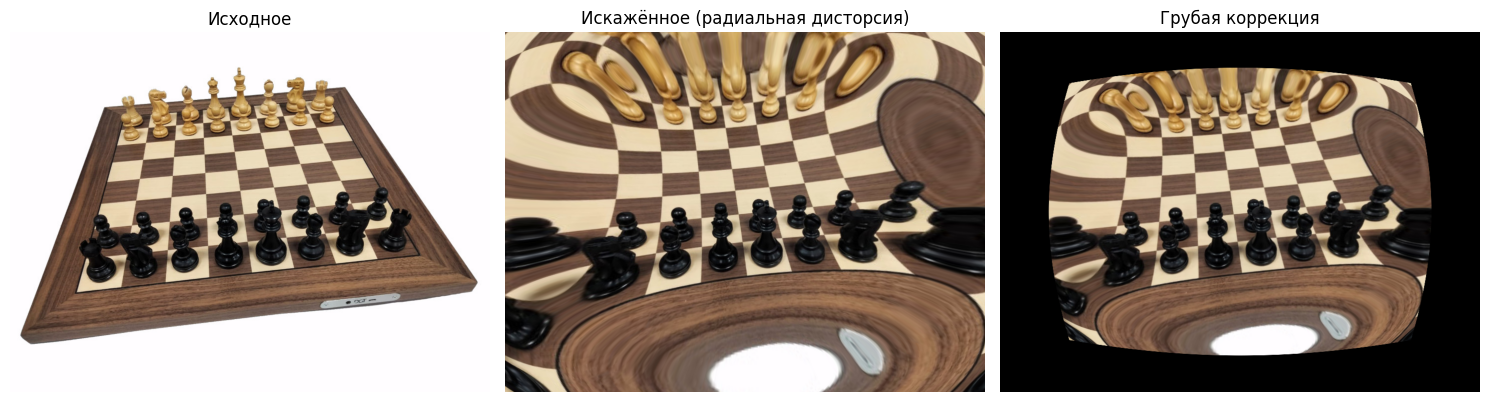

In [3]:
#@title Функции для применения радиальной дисторсии и "починки"

def apply_radial_distortion(image: np.ndarray, k1: float = -0.3, k2: float = 0.0) -> np.ndarray:
    """
    Применяю простую радиальную дисторсию:
    (x, y) -> (x', y') с учётом коэффициентов k1, k2.
    Координаты нормируются относительно центра кадра.
    """
    h, w = image.shape[:2]
    cx, cy = w / 2.0, h / 2.0

    # Координатные сетки
    xs, ys = np.meshgrid(np.arange(w), np.arange(h))

    # Нормировка в [-1, 1]
    x = (xs - cx) / cx
    y = (ys - cy) / cy

    r2 = x**2 + y**2
    radial = 1 + k1 * r2 + k2 * r2**2

    x_dist = x * radial
    y_dist = y * radial

    # Обратно к пикселям
    map_x = (x_dist * cx + cx).astype(np.float32)
    map_y = (y_dist * cy + cy).astype(np.float32)

    distorted = cv2.remap(
        image, map_x, map_y, interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0)
    )
    return distorted

def approximate_undistort(image: np.ndarray, k1: float = -0.3, k2: float = 0.0) -> np.ndarray:
    """
    Грубая "починка": применяю модель с противоположным знаком k1, k2.
    Это не точная инверсия, но визуально частично компенсирует дисторсию.
    В реальных задачах вместо этого используют калибровку и cv2.undistort().
    """
    return apply_radial_distortion(image, k1=-k1, k2=-k2)

# Применяем дисторсию и восстановление
k1_demo = -0.4  # отрицательное — бочкообразная дисторсия
img_distorted = apply_radial_distortion(img_rgb, k1=k1_demo)
img_restored = approximate_undistort(img_distorted, k1=k1_demo)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Исходное")

plt.subplot(1, 3, 2)
plt.imshow(img_distorted)
plt.axis("off")
plt.title("Искажённое (радиальная дисторсия)")

plt.subplot(1, 3, 3)
plt.imshow(img_restored)
plt.axis("off")
plt.title("Грубая коррекция")

plt.tight_layout()
plt.show()


## 3. Эпиполярная геометрия и фундаментальная матрица

В этом блоке я демонстрирую идеи из раздела про эпиполярную геометрию:

- нахожу соответствующие точки на двух изображениях;
- оцениваю фундаментальную матрицу `F`;
- строю эпиполярные линии на одном изображении для точек с другого.

Для наглядности я загружаю пару изображений (например, стереопару здания)
и показываю, что каждая точка на левом снимке даёт эпиполярную линию
на правом — ровно как на схемах в презентации.


Загрузите два файла: left.jpg и right.jpg (или переименуйте свои).


Saving left.png to left.png
Saving right.png to right.png


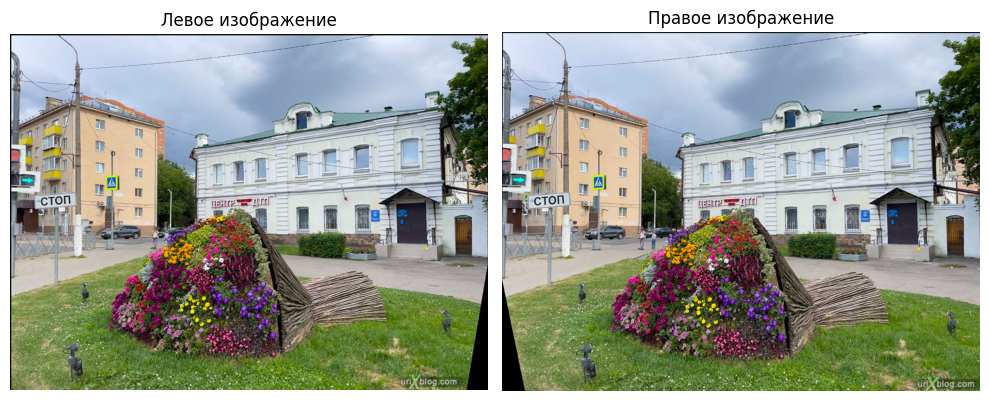

In [4]:
#@title Загрузка стерео-пары (left / right)

from google.colab import files

print("Загрузите два файла: left.jpg и right.jpg (или переименуйте свои).")
uploaded = files.upload()

left_name = [n for n in uploaded.keys() if 'left' in n.lower()][0]
right_name = [n for n in uploaded.keys() if 'right' in n.lower()][0]

imgL_bgr = cv2.imread(left_name)
imgR_bgr = cv2.imread(right_name)

imgL_gray = cv2.cvtColor(imgL_bgr, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2GRAY)

imgL_rgb = cv2.cvtColor(imgL_bgr, cv2.COLOR_BGR2RGB)
imgR_rgb = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(imgL_rgb); plt.axis("off"); plt.title("Левое изображение")
plt.subplot(1,2,2)
plt.imshow(imgR_rgb); plt.axis("off"); plt.title("Правое изображение")
plt.tight_layout()
plt.show()


ORB-признаки, фундаментальная матрица и эпиполярные линии

In [5]:
#@title Нахождение соответствий и оценка фундаментальной матрицы

# ORB-признаки
orb = cv2.ORB_create(2000)
kp1, des1 = orb.detectAndCompute(imgL_gray, None)
kp2, des2 = orb.detectAndCompute(imgR_gray, None)

# Матчер по Хэммингу
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

print("Всего совпадений:", len(matches))

# Берём верхние N лучших совпадений
N = 200
good_matches = matches[:N]

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Оценка фундаментальной матрицы с RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
print("Фундаментальная матрица F:\n", F)

pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]
print("Инлайеров:", len(pts1_inliers), "из", len(pts1))


Всего совпадений: 1107
Фундаментальная матрица F:
 [[-3.55912317e-08  6.76836404e-05 -1.83409101e-02]
 [-6.34653595e-05 -5.51954809e-07  2.09161973e-01]
 [ 1.66917050e-02 -2.05238874e-01  1.00000000e+00]]
Инлайеров: 178 из 200


Теперь построим эпиполярные линии на правом изображении для случайного поднабора точек слева.

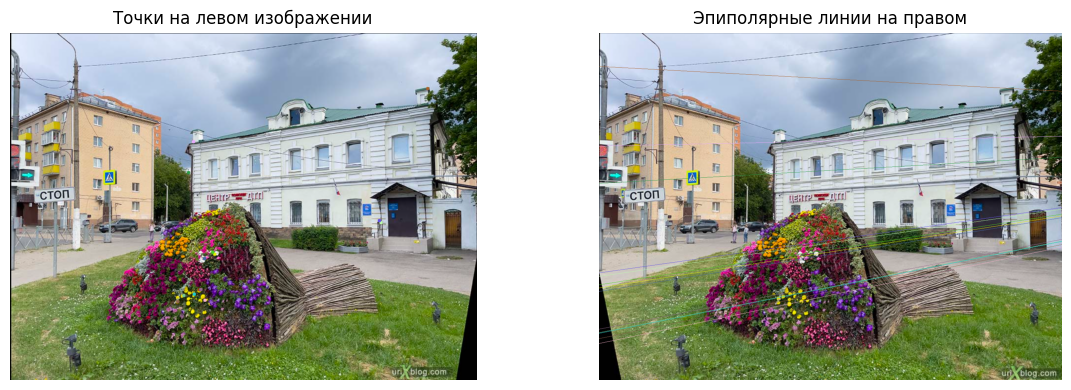

In [6]:
#@title Визуализация эпиполярных линий

def draw_epilines(img1, img2, pts1, pts2, F, num_lines=10):
    img1_c = img1.copy()
    img2_c = img2.copy()

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Случайно выбираем несколько точек-инлайеров
    idx = np.random.choice(len(pts1), size=min(num_lines, len(pts1)), replace=False)
    pts1_s = pts1[idx]
    pts2_s = pts2[idx]

    # Эпиполярные прямые для точек из первого изображения на втором
    # l2 = F * x1
    pts1_h = np.concatenate([pts1_s, np.ones((len(pts1_s), 1))], axis=1)
    lines2 = (F @ pts1_h.T).T  # shape: [N, 3]

    # Рисуем на img2 линии, на img1 точки
    for (x1, y1), (a, b, c) in zip(pts1_s, lines2):
        color = tuple(np.random.randint(0, 255, size=3).tolist())

        # Точки на первой картинке
        cv2.circle(img1_c, (int(x1), int(y1)), 5, color, -1)

        # Эпиполярная линия на второй картинке: a*x + b*y + c = 0
        x0, y0 = 0, int(-c / b) if abs(b) > 1e-6 else 0
        x1_, y1_ = w2, int(-(c + a * w2) / b) if abs(b) > 1e-6 else h2

        cv2.line(img2_c, (x0, y0), (x1_, y1_), color, 1)

    return img1_c, img2_c

imgL_epi, imgR_epi = draw_epilines(imgL_rgb, imgR_rgb, pts1_inliers, pts2_inliers, F, num_lines=15)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(imgL_epi); plt.axis("off"); plt.title("Точки на левом изображении")
plt.subplot(1,2,2)
plt.imshow(imgR_epi); plt.axis("off"); plt.title("Эпиполярные линии на правом")
plt.tight_layout()
plt.show()


## 4. Оценка глубины по одному изображению (MiDaS)

В этом блоке я показываю современный нейросетевой подход:

- беру одну RGB-картинку;
- прогоняю её через предобученную сеть MiDaS;
- получаю плотную карту глубины;
- визуализирую её и строю "псевдо-3D"-вид.

Это хороший пример связи раздела "Реконструкция по одному изображению"
и практических нейросетевых моделей глубины.


In [7]:
#@title Загрузка модели MiDaS из torch.hub (может занять время)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем устройство:", device)

midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")  # можно сменить на "DPT_Hybrid" или "MiDaS_small"
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform  # для DPT_Large / DPT_Hybrid


Используем устройство: cuda


/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:12<00:00, 107MB/s] 
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Загрузите одну картинку (например, уличная сцена, интерьер).


Saving left_1.png to left_1.png


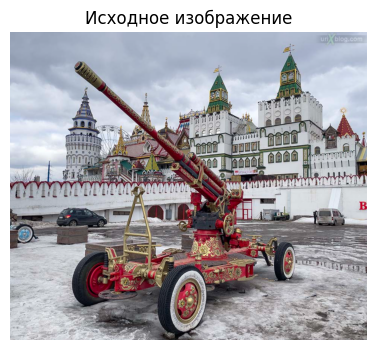

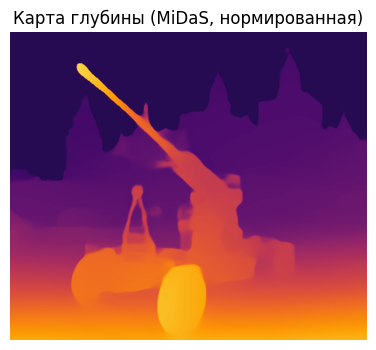

In [8]:
#@title Загрузка изображения и вычисление карты глубины

from google.colab import files

print("Загрузите одну картинку (например, уличная сцена, интерьер).")
uploaded = files.upload()
img_name = next(iter(uploaded))

img_bgr = cv2.imread(img_name)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,4))
plt.imshow(img_rgb); plt.axis("off"); plt.title("Исходное изображение")
plt.show()

# Подготовка для MiDaS
input_batch = transform(img_rgb).to(device)

with torch.no_grad():
    prediction = midas(input_batch)

# Приводим к обычному numpy
prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size=img_rgb.shape[:2],
    mode="bicubic",
    align_corners=False,
).squeeze().cpu().numpy()

# Нормализация глубины для визуализации
depth_min = prediction.min()
depth_max = prediction.max()
depth_norm = (prediction - depth_min) / (depth_max - depth_min + 1e-8)

plt.figure(figsize=(6,4))
plt.imshow(depth_norm, cmap="inferno")
plt.axis("off")
plt.title("Карта глубины (MiDaS, нормированная)")
plt.show()


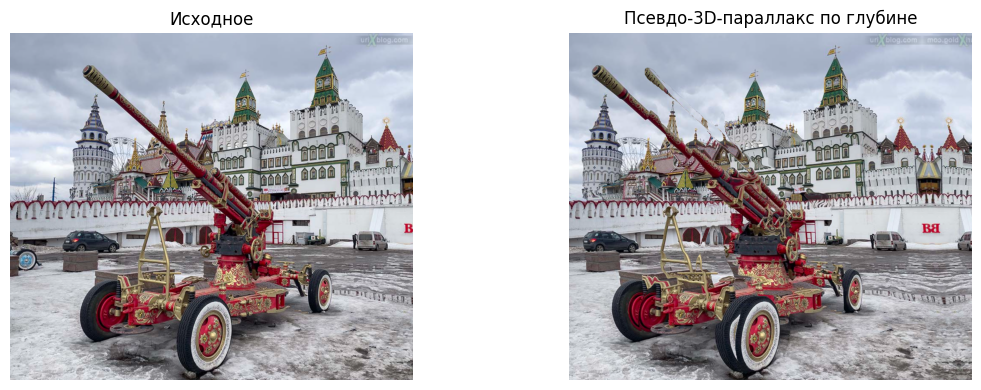

In [9]:
#@title Простейший "псевдо-3D": сдвиг по глубине

shift_scale = 200  # чем больше число, тем сильнее эффект

h, w = depth_norm.shape
xs, ys = np.meshgrid(np.arange(w), np.arange(h))

# Ближе к камере — сильнее сдвигаем
offset = (1.0 - depth_norm) * shift_scale
xs_shifted = xs + offset  # горизонтальный "параллакс"
ys_shifted = ys.astype(np.float32)

map_x = xs_shifted.astype(np.float32)
map_y = ys_shifted.astype(np.float32)

parallax = cv2.remap(img_rgb, map_x, map_y, interpolation=cv2.INTER_LINEAR,
                     borderMode=cv2.BORDER_REFLECT)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(img_rgb); plt.axis("off"); plt.title("Исходное")
plt.subplot(1,2,2)
plt.imshow(parallax); plt.axis("off"); plt.title("Псевдо-3D-параллакс по глубине")
plt.tight_layout()
plt.show()


## 5. Контуры и карта глубины: Canny / Sobel

В этом блоке я связываю две темы из лекции:

* выделение контуров (Canny / Sobel),
* модель глубины, полученную нейросетью.

Я покажу:

1. Как выглядит карта контуров по исходному изображению.
2. Как эти же контуры «накладываются» на карту глубины.
3. Как с помощью оператора Собеля можно увидеть, что градиенты глубины
   действительно усиливаются на границах объектов.

Идея для обсуждения со студентами:  
контуры — это «скелет» формы, а глубина — «плоть». Когда обе карты согласованы,
реконструкция выглядит и геометрически корректной, и визуально правдоподобной.


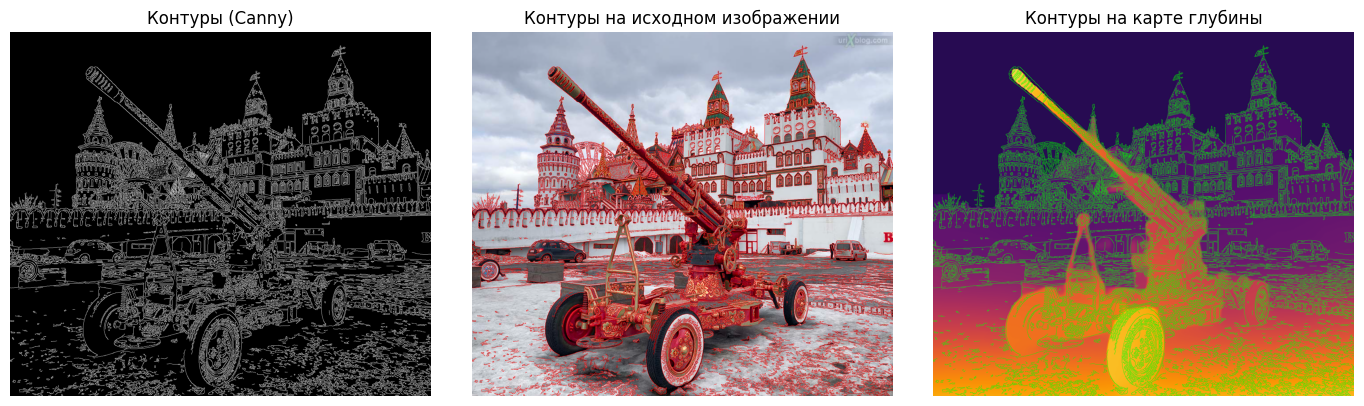

In [10]:
#@title Canny: выделение контуров и наложение на RGB и глубину
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Проверяем, что у нас есть img_rgb и depth_norm
assert 'img_rgb' in globals(), "Ожидаю, что переменная img_rgb уже существует (исходное RGB изображение)."
assert 'depth_norm' in globals(), "Ожидаю, что переменная depth_norm уже существует (нормированная карта глубины)."

# Переводим в градации серого
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Параметры Canny можно подстроить под демонстрацию
edges = cv2.Canny(img_gray, threshold1=100, threshold2=200)

# Готовим цветные версии для наложения
rgb_vis = img_rgb.copy()
depth_color = plt.cm.inferno(depth_norm)[:, :, :3]  # colormap -> RGB в [0,1]
depth_color_uint8 = (depth_color * 255).astype(np.uint8)

# Маска контуров (там, где edges > 0)
edge_mask = edges > 0

# Накладываем контуры красным цветом
overlay_rgb = rgb_vis.copy()
overlay_rgb[edge_mask] = [255, 0, 0]  # красные линии

overlay_depth = depth_color_uint8.copy()
overlay_depth[edge_mask] = [0, 255, 0]  # зелёные линии

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.axis("off")
plt.title("Контуры (Canny)")

plt.subplot(1, 3, 2)
plt.imshow(overlay_rgb)
plt.axis("off")
plt.title("Контуры на исходном изображении")

plt.subplot(1, 3, 3)
plt.imshow(overlay_depth)
plt.axis("off")
plt.title("Контуры на карте глубины")

plt.tight_layout()
plt.show()


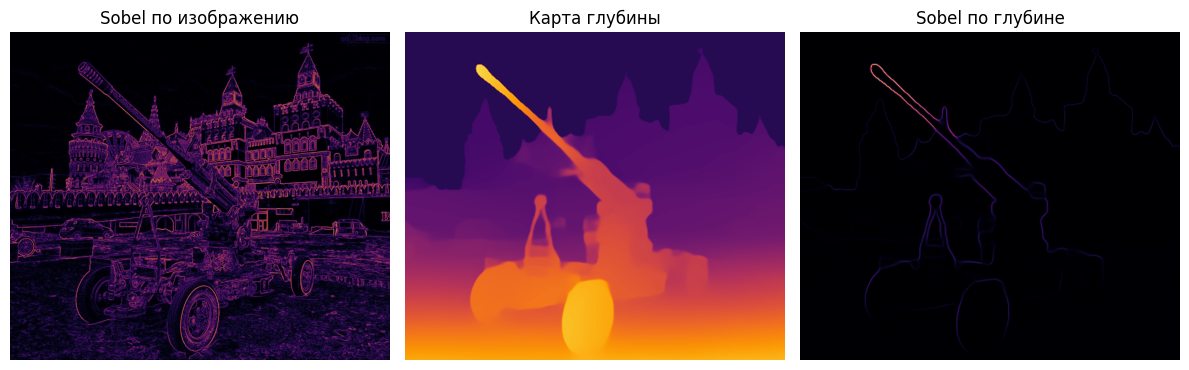

In [11]:
#@title Sobel: градиенты по изображению и по глубине

# Sobel по изображению (градации серого)
sobelx_img = cv2.Sobel(img_gray, cv2.CV_32F, 1, 0, ksize=3)
sobely_img = cv2.Sobel(img_gray, cv2.CV_32F, 0, 1, ksize=3)
grad_mag_img = np.sqrt(sobelx_img**2 + sobely_img**2)
grad_mag_img_norm = (grad_mag_img / (grad_mag_img.max() + 1e-8))

# Sobel по глубине
depth_float = depth_norm.astype(np.float32)
sobelx_depth = cv2.Sobel(depth_float, cv2.CV_32F, 1, 0, ksize=3)
sobely_depth = cv2.Sobel(depth_float, cv2.CV_32F, 0, 1, ksize=3)
grad_mag_depth = np.sqrt(sobelx_depth**2 + sobely_depth**2)
grad_mag_depth_norm = (grad_mag_depth / (grad_mag_depth.max() + 1e-8))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(grad_mag_img_norm, cmap='inferno')
plt.axis("off")
plt.title("Sobel по изображению")

plt.subplot(1, 3, 2)
plt.imshow(depth_norm, cmap='inferno')
plt.axis("off")
plt.title("Карта глубины")

plt.subplot(1, 3, 3)
plt.imshow(grad_mag_depth_norm, cmap='inferno')
plt.axis("off")
plt.title("Sobel по глубине")

plt.tight_layout()
plt.show()


## 6. Мини-демо визуального теста Тьюринга

Здесь я делаю упрощённый визуальный тест Тьюринга:

1. Беру исходное изображение `img_rgb`.
2. Беру "реконструктированное" изображение:
   *либо псевдо-3D по глубине (`parallax`), либо, если его нет, просто слегка размытую версию*.
3. Случайным образом выбираю, какое из них будет **A**, какое **B**.
4. Показываю пару A/B студентам и прошу проголосовать:
   *"Какое из них, по-вашему, исходное?"*.
5. В отдельной ячейке раскрываю правильный ответ.

Такой интерактив хорошо иллюстрирует идею со слайдов:
если аудитория систематически ошибается, значит реконструкция визуально
очень близка к оригиналу.


## Визуальный тест Тьюринга: практический мини-эксперимент

Сейчас я хочу показать вам простой вариант **визуального теста Тьюринга**
для реконструкции изображений.

Идея такая. Я беру исходное фото и строю его «реконструкцию»:
слегка сжимаю, восстанавливаю назад и чуть размываю.
То есть имитирую работу какого-нибудь алгоритма реконструкции, который
немного портит картинку, но старается сохранить её визуальный вид.

Дальше я случайным образом выбираю, какое изображение показать вам как **A**,
а какое как **B**. Одно из них — оригинал, второе — реконструкция.
На экране вы видите их рядом и только подписи «Изображение A» и «Изображение B».

У меня здесь есть маленький «регулятор сложности»:
в выпадающем списке `difficulty` я могу выбрать режим _easy_, _medium_ или _hard_.
В режиме easy реконструкция заметно хуже — можно увидеть лёгкую потерю резкости
и деталей. В режиме hard отличия минимальны, и тогда тест становится действительно
похож на тест Тьюринга: нужно внимательно всматриваться, чтобы сделать выбор.

Ваше задание очень простое: **по ощущениям выбрать, где оригинал — A или B**.
Мы голосуем, а потом я запускаю следующую ячейку и показываю правильный ответ.

Если при режиме hard большинство из вас начинает ошибаться,  
это означает, что визуально реконструкция уже очень близка к исходнику:
человеческому наблюдателю становится трудно уверенно отличить их друг от друга.
Ровно это и есть интуиция визуального теста Тьюринга, о которой мы говорили на слайдах.


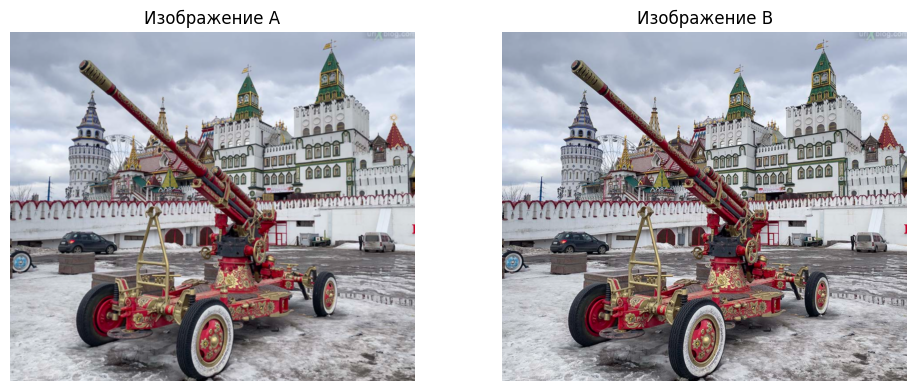

**Режим сложности:** `medium`, `crop_frac=0.97`  

**Вопрос студентам:** какое из изображений, A или B, вы считаете *исходным*?

Проголосуйте, а затем запустите ячейку с раскрытием ответа.

In [12]:
#@title Генерация пары A/B для визуального теста Тьюринга (c регулятором сложности)
import random
from IPython.display import display, Markdown

assert 'img_rgb' in globals(), "Ожидаю, что img_rgb уже существует."

def make_soft_reconstruction(img: np.ndarray, level: str = "medium") -> np.ndarray:
    """
    Создаю «реконструированное» изображение без геометрических сдвигов:
    - даунскейл-апскейл,
    - небольшое размытие.
    level регулирует, насколько сильно мы портим картинку.
    """
    h, w = img.shape[:2]

    if level == "easy":
        scale = 0.6     # сильнее сжали → заметнее деградация
        blur_ksize = 7
        blur_sigma = 1.2
    elif level == "hard":
        scale = 0.9     # почти не сжимаем → отличить трудно
        blur_ksize = 3
        blur_sigma = 0.4
    else:  # "medium"
        scale = 0.75
        blur_ksize = 5
        blur_sigma = 0.8

    # даунскейл-апскейл
    low = cv2.resize(img, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
    up = cv2.resize(low, (w, h), interpolation=cv2.INTER_CUBIC)

    # лёгкое размытие
    if blur_ksize % 2 == 0:
        blur_ksize += 1  # ядро свёртки должно быть нечётным
    recon = cv2.GaussianBlur(up, (blur_ksize, blur_ksize), blur_sigma)

    return recon

def center_crop(img: np.ndarray, crop_frac: float = 0.95) -> np.ndarray:
    """
    Небольшой центр-кроп, чтобы убрать крайние артефакты
    и сделать кадры ещё ближе по содержанию.
    """
    h, w = img.shape[:2]
    ch, cw = int(h * crop_frac), int(w * crop_frac)
    y0 = (h - ch) // 2
    x0 = (w - cw) // 2
    cropped = img[y0:y0+ch, x0:x0+cw]
    return cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)

# --- регуляторы для лектора (Colab-панель) ---
difficulty = "medium"  #@param ["easy", "medium", "hard"] {type:"string"}
crop_frac = 0.97     #@param {type:"slider", min:0.90, max:0.99, step:0.01}

# исходное и "реконструкция"
orig_proc = center_crop(img_rgb, crop_frac=crop_frac)
recon_raw = make_soft_reconstruction(img_rgb, level=difficulty)
recon_proc = center_crop(recon_raw, crop_frac=crop_frac)

# сохраняем копии для последующего анализа
turing_orig = orig_proc.copy()
turing_recon = recon_proc.copy()


# случайный порядок A/B
order = random.choice(['orig_first', 'rec_first'])
if order == 'orig_first':
    imgA, imgB = orig_proc, recon_proc
else:
    imgA, imgB = recon_proc, orig_proc

turing_state = {'order': order, 'difficulty': difficulty, 'crop_frac': crop_frac}

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(imgA)
plt.axis("off")
plt.title("Изображение A")

plt.subplot(1, 2, 2)
plt.imshow(imgB)
plt.axis("off")
plt.title("Изображение B")

plt.tight_layout()
plt.show()

display(Markdown(
    f"**Режим сложности:** `{difficulty}`, `crop_frac={crop_frac:.2f}`  \n\n"
    "**Вопрос студентам:** какое из изображений, A или B, вы считаете *исходным*?\n\n"
    "Проголосуйте, а затем запустите ячейку с раскрытием ответа."
))


In [13]:
#@title Раскрытие ответа теста Тьюринга

if 'turing_state' not in globals():
    print("Сначала запустите ячейку генерации пары A/B.")
else:
    order = turing_state['order']
    if order == 'orig_first':
        msg = (
            "В этот раз **исходное изображение** было: **A**, "
            "а **B** — реконструкция."
        )
    else:
        msg = (
            "В этот раз **исходное изображение** было: **B**, "
            "а **A** — реконструкция."
        )
    display(Markdown("### Ответ\n" + msg))


### Ответ
В этот раз **исходное изображение** было: **B**, а **A** — реконструкция.

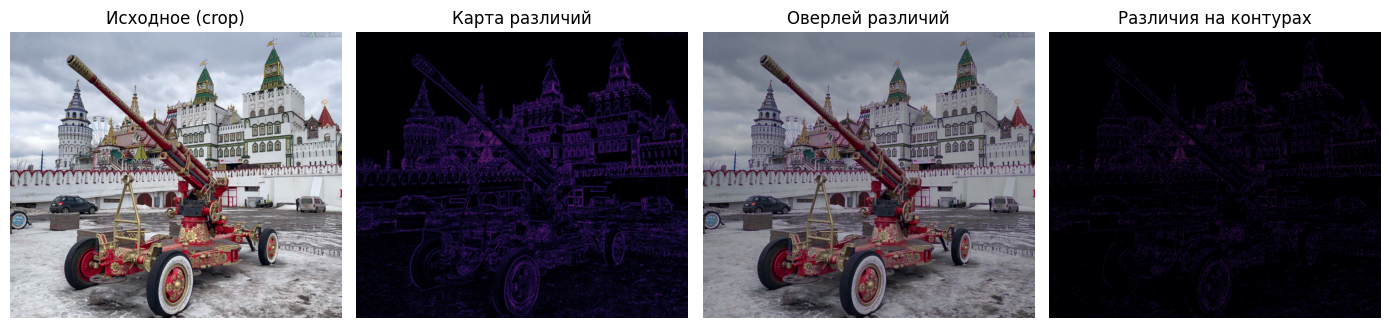

На **карте различий** яркие области показывают, где реконструкция сильнее всего отличается от исходника.  
На изображении **«Различия на контурах»** мы оставили только те различия, которые лежат вдоль контуров объектов — это иллюстрирует идею из лекции о важности контуров для визуального восприятия и реконструкции.

In [14]:
#@title Подсветка различий между исходным и реконструированным изображениями
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display, Markdown

if 'turing_orig' not in globals() or 'turing_recon' not in globals():
    print("Сначала запустите ячейку генерации пары A/B с последней версией кода.")
else:
    orig = turing_orig.astype(np.float32) / 255.0
    recon = turing_recon.astype(np.float32) / 255.0

    # 1) скалярная карта различий (среднее по каналам)
    diff = np.abs(orig - recon)          # H×W×3
    diff_scalar = diff.mean(axis=2)      # H×W
    diff_norm = diff_scalar / (diff_scalar.max() + 1e-8)

    # 2) тепловая карта различий
    cmap = plt.get_cmap('magma')
    heat = cmap(diff_norm)[..., :3]      # H×W×3, в 0..1

    # 3) наложение heatmap на оригинал
    overlay = 0.7 * orig + 0.3 * heat    # подмешиваем тепловую карту

    # 4) отличия вдоль контуров (Canny по оригиналу)
    gray = cv2.cvtColor((orig * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_mask = edges > 0

    diff_edges = np.zeros_like(diff_norm)
    diff_edges[edge_mask] = diff_norm[edge_mask]

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(orig)
    plt.axis("off")
    plt.title("Исходное (crop)")

    plt.subplot(1, 4, 2)
    plt.imshow(diff_norm, cmap='magma')
    plt.axis("off")
    plt.title("Карта различий")

    plt.subplot(1, 4, 3)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Оверлей различий")

    plt.subplot(1, 4, 4)
    plt.imshow(diff_edges, cmap='magma')
    plt.axis("off")
    plt.title("Различия на контурах")

    plt.tight_layout()
    plt.show()

    display(Markdown(
        "На **карте различий** яркие области показывают, где реконструкция "
        "сильнее всего отличается от исходника.  \n"
        "На изображении **«Различия на контурах»** мы оставили только те "
        "различия, которые лежат вдоль контуров объектов — это иллюстрирует "
        "идею из лекции о важности контуров для визуального восприятия и реконструкции."
    ))


## Устанавливаем и загружаем stabilityai/stable-diffusion-2-depth-модель

In [20]:
#@title Установка и загрузка SD 1.5 + ControlNet Depth
!pip install -q diffusers transformers accelerate safetensors

import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Устройство для генерации:", device)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
)

pipe_depth = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
)

pipe_depth.scheduler = UniPCMultistepScheduler.from_config(pipe_depth.scheduler.config)
pipe_depth = pipe_depth.to(device)

# чуть экономим память
pipe_depth.enable_attention_slicing()
print("Модель для генерации по глубине загружена.")


Устройство для генерации: cuda


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Модель для генерации по глубине загружена.


- turing_orig и turing_recon (crop’ы из теста Тьюринга),

- MiDaS + transform (мы ими уже пользовались ранее).

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

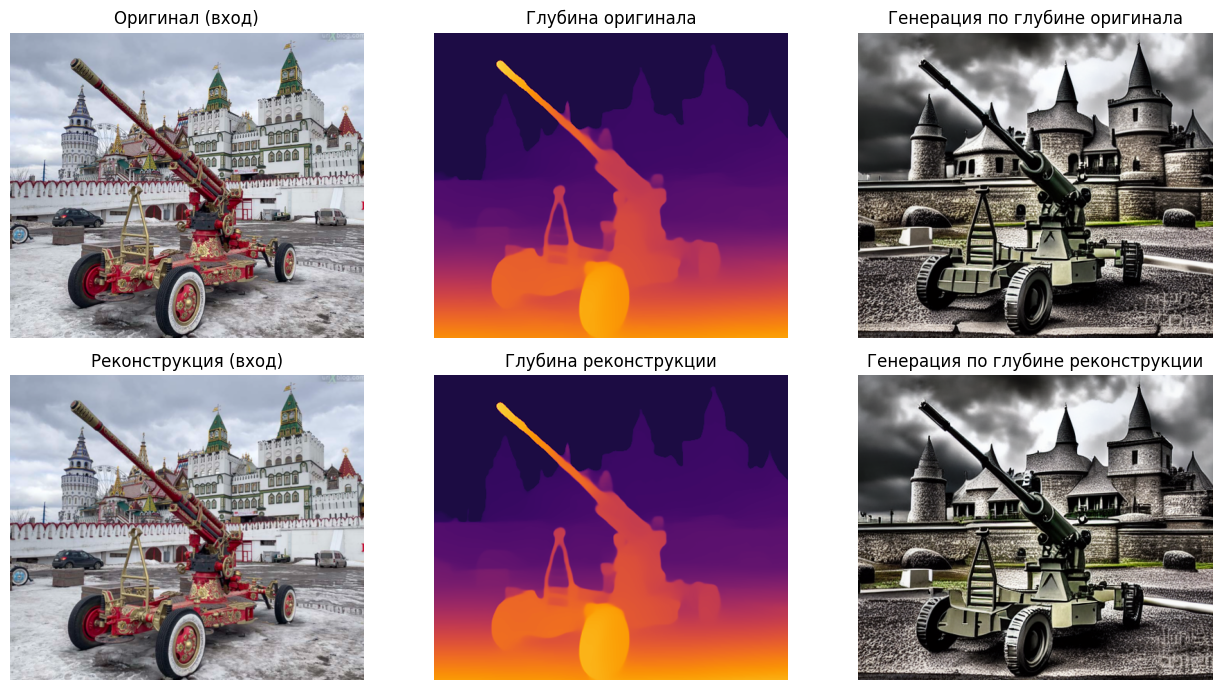

In [21]:
#@title Генерация по карте глубины оригинала и реконструкции (ControlNet Depth)

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

assert 'turing_orig' in globals() and 'turing_recon' in globals(), "Нужны turing_orig/turing_recon (блок визуального теста)."
assert 'midas' in globals() and 'transform' in globals(), "Ожидаю, что MiDaS уже загружен и есть transform."
assert 'pipe_depth' in globals(), "Сначала запусти ячейку с загрузкой ControlNet Depth."

def estimate_depth_midas(img_rgb: np.ndarray) -> np.ndarray:
    """
    Оцениваем нормированную карту глубины для RGB-изображения (H×W×3, 0..255, RGB).
    Возвращает depth в [0, 1] (относительная глубина).
    """
    img = img_rgb.copy()
    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

    prediction = F.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze().cpu().numpy()

    dmin, dmax = prediction.min(), prediction.max()
    depth_norm = (prediction - dmin) / (dmax - dmin + 1e-8)
    return depth_norm

def depth_to_pil(depth_norm: np.ndarray) -> Image.Image:
    """Нормированную глубину [0,1] → 3-канальное grayscale-изображение для ControlNet."""
    depth_8 = (depth_norm * 255.0).clip(0, 255).astype("uint8")
    rgb = np.stack([depth_8]*3, axis=-1)
    return Image.fromarray(rgb)

def resize_for_sd(img: np.ndarray, max_side: int = 512) -> np.ndarray:
    """Аккуратно уменьшаем изображение, чтобы уложиться в память."""
    h, w = img.shape[:2]
    scale = max_side / max(h, w)
    if scale < 1.0:
        new_w, new_h = int(w * scale), int(h * scale)
        img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    else:
        img_resized = img
    return img_resized

# Берём те же кадры, что и в тесте Тьюринга
orig_rgb = resize_for_sd(turing_orig)
recon_rgb = resize_for_sd(turing_recon)

# Оцениваем глубину
depth_orig = estimate_depth_midas(orig_rgb)
depth_recon = estimate_depth_midas(recon_rgb)

depth_orig_pil = depth_to_pil(depth_orig)
depth_recon_pil = depth_to_pil(depth_recon)

# Общий текстовый промпт
prompt = "high quality realistic photo of an ornate anti-aircraft gun in front of a castle, overcast sky, highly detailed"
negative_prompt = "low quality, blurry, distorted, bad perspective"

num_inference_steps = 20
guidance_scale = 7.5
seed = 1234

# Генерация с глубиной ОРИГИНАЛА
generator = torch.Generator(device=device).manual_seed(seed)
result_orig = pipe_depth(
    prompt=prompt,
    image=depth_orig_pil,          # для depth-ControlNet подаём depth-картинку
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    negative_prompt=negative_prompt,
    generator=generator,
).images[0]

# Генерация с глубиной РЕКОНСТРУКЦИИ (тот же prompt и seed)
generator = torch.Generator(device=device).manual_seed(seed)
result_recon = pipe_depth(
    prompt=prompt,
    image=depth_recon_pil,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    negative_prompt=negative_prompt,
    generator=generator,
).images[0]

plt.figure(figsize=(13, 7))

plt.subplot(2, 3, 1)
plt.imshow(orig_rgb)
plt.axis("off")
plt.title("Оригинал (вход)")

plt.subplot(2, 3, 2)
plt.imshow(depth_orig, cmap="inferno")
plt.axis("off")
plt.title("Глубина оригинала")

plt.subplot(2, 3, 3)
plt.imshow(result_orig)
plt.axis("off")
plt.title("Генерация по глубине оригинала")

plt.subplot(2, 3, 4)
plt.imshow(recon_rgb)
plt.axis("off")
plt.title("Реконструкция (вход)")

plt.subplot(2, 3, 5)
plt.imshow(depth_recon, cmap="inferno")
plt.axis("off")
plt.title("Глубина реконструкции")

plt.subplot(2, 3, 6)
plt.imshow(result_recon)
plt.axis("off")
plt.title("Генерация по глубине реконструкции")

plt.tight_layout()
plt.show()
